In [14]:
import numpy as np
import pandas as pd

from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## LOAD DATA

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


## VISUALIZATION

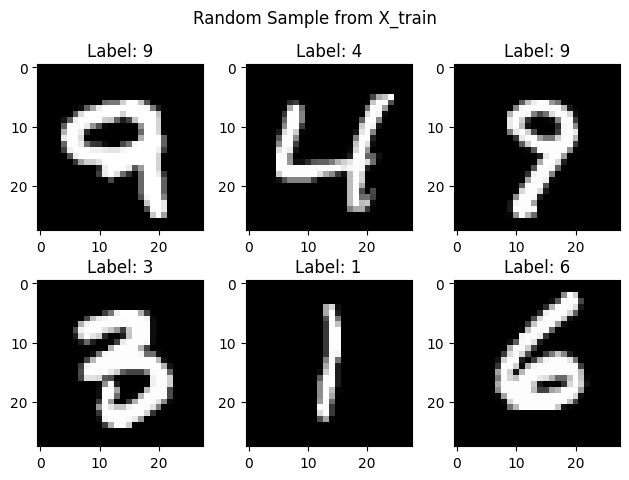

In [3]:
random_index = np.random.randint(1, x_train.shape[0], 6)

for idx, index in enumerate(random_index, start=1):
  plt.subplot(2, 3, idx)
  plt.imshow(x_train[index], cmap="gray")
  plt.title(f"Label: {y_train[index]}")

plt.suptitle("Random Sample from X_train")
plt.tight_layout()
plt.show()

In [4]:
X_train = x_train.reshape(-1, 28, 28, 1).astype("float32")
X_test = x_test.reshape(-1, 28, 28, 1).astype("float32")

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

## Normalization

In [5]:
X_train /= 255
X_test /= 255

## Modelling

In [6]:
model_input = Input(shape=X_train.shape[1:])
x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu")(model_input)
x = MaxPooling2D()(x)
x = Dropout(rate=0.5)(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu")(x)
x = MaxPooling2D()(x)
x = Dropout(rate=0.5)(x)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=(2, 2), strides=(1, 1), activation="relu", padding="valid")(x)
x = MaxPooling2D()(x)
x = Dropout(rate=0.5)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(units=64, activation="relu", kernel_regularizer=L1L2())(x)
x = Dense(units=32, activation="relu", kernel_regularizer=L1L2())(x)
output = Dense(units=len(set(y_train)), activation="softmax")(x)

f_c_model = Model(inputs=model_input, outputs=output)

f_c_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 128)       0         
                                                                 
 batch_normalization (Batch  (None, 13, 13, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        73792 

* Note: We use categorical_crossentropy when the target is one-hot-encoded and sparse_categorical_crossentropy when the target is not one-hot-endoded

In [9]:
f_c_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
history_1 = f_c_model.fit(x=X_train, y=Y_train,
                          validation_data=(X_test, Y_test),
                          epochs=10,
                          batch_size=32,
                          callbacks=[EarlyStopping(patience=2)])

Epoch 1/10
1875/1875 [==============================] - 196s 104ms/step - loss: 0.4763 - accuracy: 0.8466 - val_loss: 0.0799 - val_accuracy: 0.9750
Epoch 2/10
1875/1875 [==============================] - 181s 97ms/step - loss: 0.2150 - accuracy: 0.9335 - val_loss: 0.0603 - val_accuracy: 0.9814
Epoch 3/10
1875/1875 [==============================] - 179s 95ms/step - loss: 0.1876 - accuracy: 0.9418 - val_loss: 0.0610 - val_accuracy: 0.9820
Epoch 4/10
1875/1875 [==============================] - 180s 96ms/step - loss: 0.1708 - accuracy: 0.9475 - val_loss: 0.0503 - val_accuracy: 0.9840
Epoch 5/10
1875/1875 [==============================] - 175s 93ms/step - loss: 0.1597 - accuracy: 0.9517 - val_loss: 0.0616 - val_accuracy: 0.9823
Epoch 6/10
1875/1875 [==============================] - 175s 93ms/step - loss: 0.1553 - accuracy: 0.9530 - val_loss: 0.0552 - val_accuracy: 0.9846


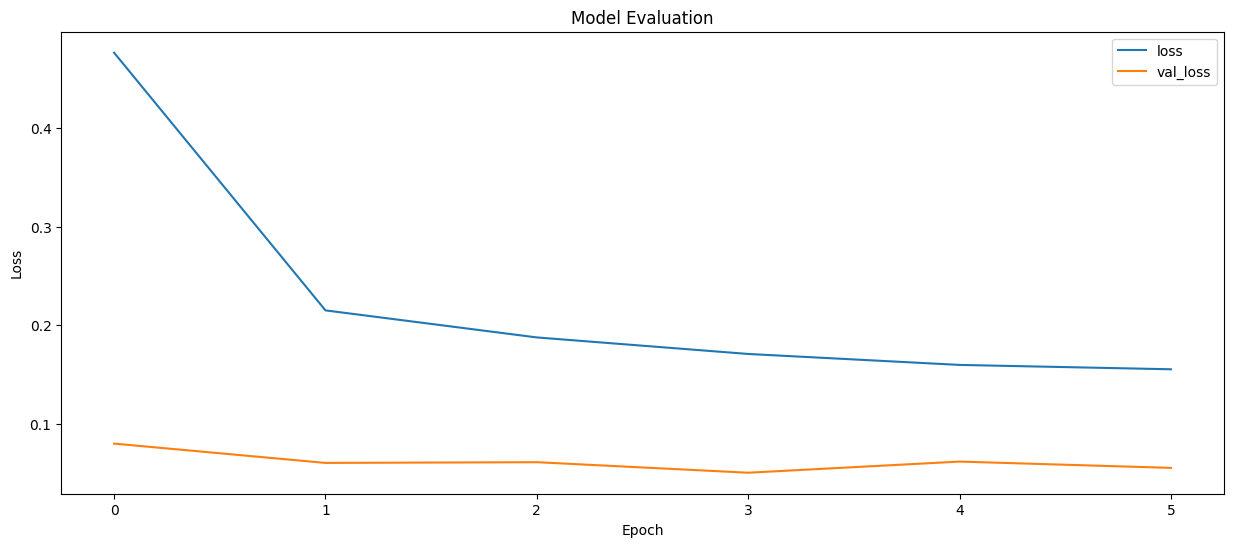

In [11]:
pd.DataFrame(history_1.history)[["loss", "val_loss"]].plot(figsize=(15, 6), xlabel="Epoch", ylabel="Loss", title="Model Evaluation")
plt.show()

In [12]:
prediction = np.argmax(f_c_model.predict(X_test), axis=1)

313/313 [==============================] - 7s 20ms/step


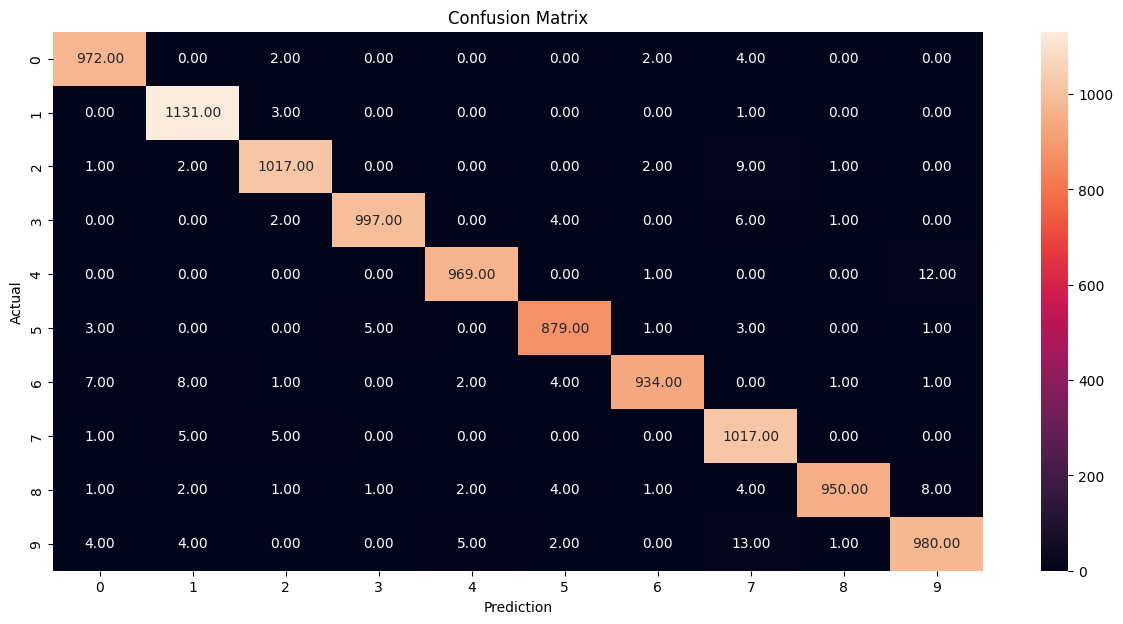

In [15]:
plt.figure(figsize=(15, 7))
sns.heatmap(metrics.confusion_matrix(y_test, prediction), annot=True, fmt=".2f")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [16]:
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.97      0.98       958
           7       0.96      0.99      0.98      1028
           8       1.00      0.98      0.99       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [22]:
f_c_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [23]:
history_2 = f_c_model.fit(x=X_train, y=y_train,
                          validation_data=(X_test, y_test),
                          epochs=10,
                          batch_size=32,
                          callbacks=[EarlyStopping(patience=2)])

Epoch 1/10
1875/1875 [==============================] - 180s 95ms/step - loss: 0.1485 - accuracy: 0.9560 - val_loss: 0.0495 - val_accuracy: 0.9843
Epoch 2/10
1875/1875 [==============================] - 172s 92ms/step - loss: 0.1464 - accuracy: 0.9567 - val_loss: 0.0472 - val_accuracy: 0.9862
Epoch 3/10
1875/1875 [==============================] - 175s 94ms/step - loss: 0.1421 - accuracy: 0.9576 - val_loss: 0.0538 - val_accuracy: 0.9846
Epoch 4/10
1875/1875 [==============================] - 174s 93ms/step - loss: 0.1400 - accuracy: 0.9589 - val_loss: 0.0430 - val_accuracy: 0.9874
Epoch 5/10
1875/1875 [==============================] - 175s 94ms/step - loss: 0.1373 - accuracy: 0.9599 - val_loss: 0.0487 - val_accuracy: 0.9862
Epoch 6/10
1875/1875 [==============================] - 170s 91ms/step - loss: 0.1336 - accuracy: 0.9611 - val_loss: 0.0407 - val_accuracy: 0.9878
Epoch 7/10
1875/1875 [==============================] - 173s 92ms/step - loss: 0.1327 - accuracy: 0.9604 - val_loss: 0

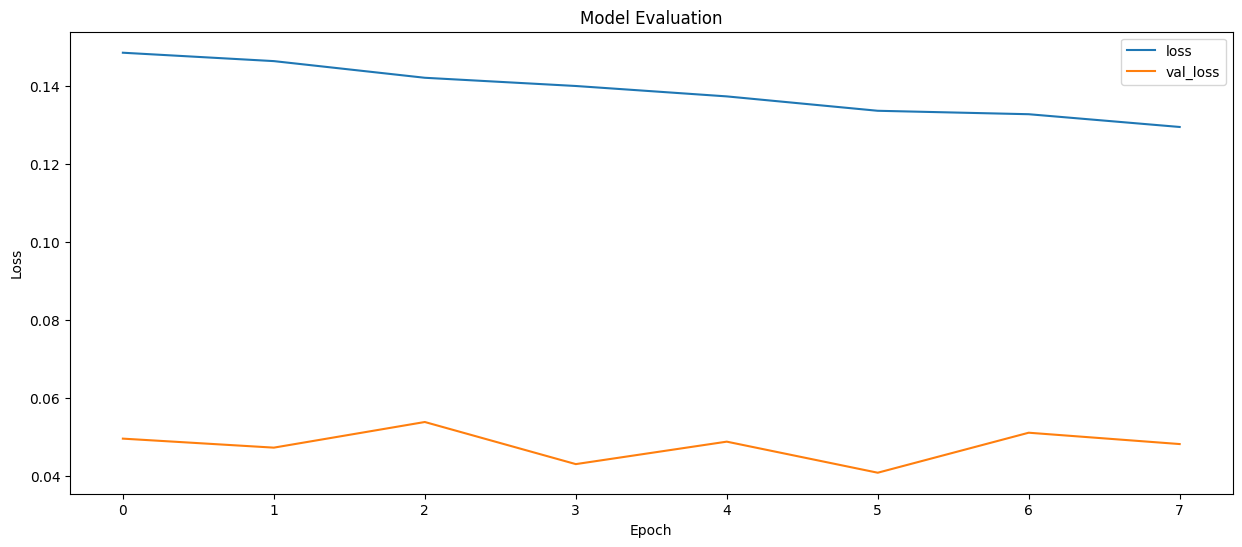

In [24]:
pd.DataFrame(history_2.history)[["loss", "val_loss"]].plot(figsize=(15, 6), xlabel="Epoch", ylabel="Loss", title="Model Evaluation")
plt.show()

In [25]:
prediction_1 = np.argmax(f_c_model.predict(X_test), axis=1)

313/313 [==============================] - 6s 20ms/step


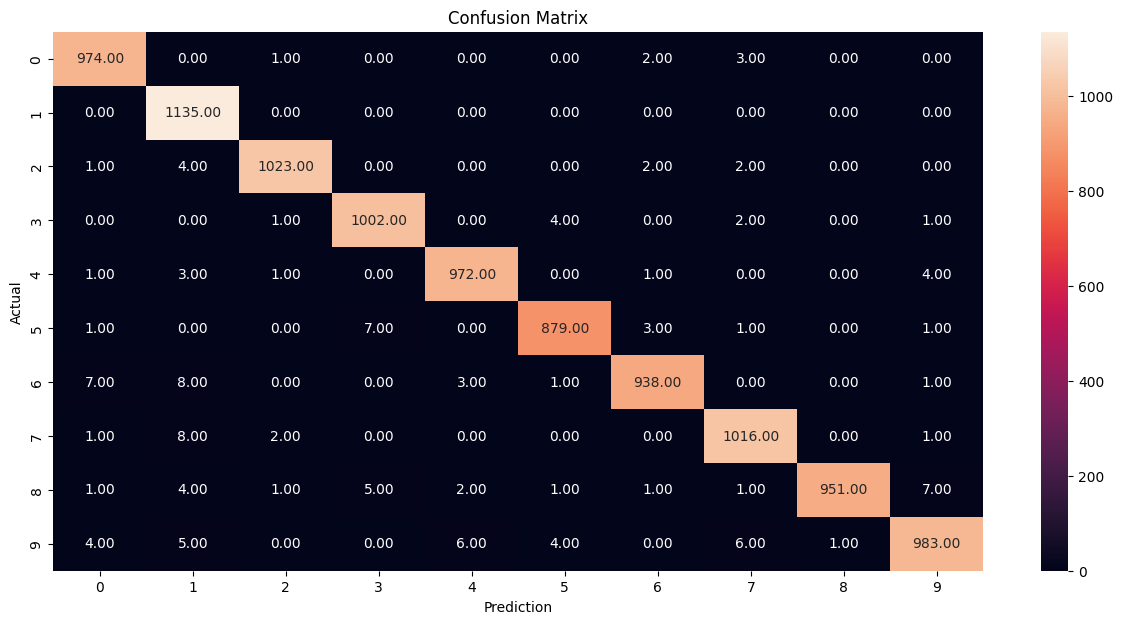

In [26]:
plt.figure(figsize=(15, 7))
sns.heatmap(metrics.confusion_matrix(y_test, prediction_1), annot=True, fmt=".2f")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# Eddy